In [1]:
# import required libraries
import os, sys
import numpy as np, pandas as pd, seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.metrics import r2_score
import matplotlib.lines as mlines
import warnings
# Settings for matplotlib
plt.rcParams["font.family"] = "Arial"
mpl.rcParams['axes.linewidth'] = 2
plt.rcParams.update({'font.size': 20})
warnings.filterwarnings('ignore')
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['font.family'] = 'Arial'
sns.set_context('poster')

In [2]:
# Load All measured RDC Datasets for reference:
E0_rdc = pd.read_csv("data/RDC_Data/E0-wt-TAR.sas.csv")
EI22_rdc = pd.read_csv("data/RDC_Data/EI22-wt-TAR.sas.csv")
EII3_rdc = pd.read_csv("data/RDC_Data/EII3-wt-TAR.sas.csv")
EII13_rdc = pd.read_csv("data/RDC_Data/EII13-wt-TAR.sas.csv")

E0_N = E0_rdc.shape[0]
EI22_N = EI22_rdc.shape[0]
EII3_N = EII3_rdc.shape[0]
EII13_N = EII13_rdc.shape[0]

E0_rdc["construct"] = "E0"
EI22_rdc["construct"] = "EI22"
EII3_rdc["construct"] = "EII3"
EII13_rdc["construct"] = "EII13"

All_rdc = pd.concat([E0_rdc, EI22_rdc, EII3_rdc, EII13_rdc], ignore_index=True).drop(columns = "qc")
print("Read in total of %d RDCs:"%(All_rdc.shape[0]))

Read in total of 118 RDCs:


In [3]:
# Create masks for different domains and constructs:
df = All_rdc.copy()
maskE0 = df["construct"] == "E0"
maskEI22 = df["construct"] == "EI22"
maskEII3 = df["construct"] == "EII3"
maskEII13 = df["construct"] == "EII13"
maskH1 = (df.res_id_1.isin([18, 19, 20 ,21, 22]) | df.res_id_1.isin([40, 41, 42, 43, 44]))
maskH2 = (df.res_id_1.isin([27, 28, 29]) | df.res_id_1.isin([36, 37, 38]))
maskL = df.res_id_1.isin([30, 31, 32, 33, 34, 35])
maskB = df.res_id_1.isin([23, 24, 25])

In [4]:
# Define function for scaling PALES predicted RDCs wrt measured RDCs:
def get_scaled_rdcs(pm):
    mff = All_rdc.copy() 
    pmm = pm.copy()     
    pm = np.mean(pmm, axis=1)    
    maskE0 = mff["construct"] == "E0"
    maskEI22 = mff["construct"] == "EI22"
    maskEII3 = mff["construct"] == "EII3"
    maskEII13 = mff["construct"] == "EII13"
    mm = np.array(mff["rdc"], dtype=float)
    LE0 = np.dot(mm[maskE0],pm[maskE0])/np.dot(pm[maskE0],pm[maskE0])
    LEI22 = np.dot(mm[maskEI22],pm[maskEI22])/np.dot(pm[maskEI22],pm[maskEI22])
    LEII3 = np.dot(mm[maskEII3],pm[maskEII3])/np.dot(pm[maskEII3],pm[maskEII3])
    LEII13 = np.dot(mm[maskEII13],pm[maskEII13])/np.dot(pm[maskEII13],pm[maskEII13])
    pmm[maskE0] = pmm[maskE0] * LE0
    pmm[maskEI22] = pmm[maskEI22] * LEI22
    pmm[maskEII3] = pmm[maskEII3] * LEII3
    pmm[maskEII13] = pmm[maskEII13] * LEII13
    scaled_pm = pmm.copy()
    scaled_mm = mm.copy()
    return scaled_pm, scaled_mm


# Define function for calculating coeff of determination for ens. model RDCs
def calc_r2_denovo(x, y):
    TSS = np.sum((x - np.mean(x))**2)
    RSS = np.sum((x - y)**2)
    return (1-RSS/TSS)

In [6]:
fin = open("data/Unbiased_SAS_1To50_500K.txt", "r")
All_RMSD = []
H1_RMSD = []
H2_RMSD = []
B_RMSD = []
L_RMSD = []

All_R2 = []
H1_R2 = []
H2_R2 = []
B_R2 = []
L_R2 = []

for line in fin:
    words = line.strip().split()
    N = int(words[0])
    Indices = words[-N:]
    Indices = [int(i) for i in Indices]
    print(Indices)

    pm = np.genfromtxt("data/Unbiased_Lib_All_Data/Unbiased_pmatrix.txt", dtype=float)[:, Indices]
    mm = np.genfromtxt("data/mmatrix.txt", dtype=float)
    scaled_pm, mm = get_scaled_rdcs(pm)
    scaled_pm = np.mean(scaled_pm, axis=1)
    scaled_mm = mm
    
    x = scaled_mm
    y = scaled_pm
    RMSD = np.sqrt(np.mean((x-y)**2))
    R = np.corrcoef(x, y)[0, 1]
    All_RMSD.append(RMSD)
    All_R2.append(R)
    
    x = scaled_mm[maskH1]
    y = scaled_pm[maskH1]
    RMSD = np.sqrt(np.mean((x-y)**2))
    R = np.corrcoef(x, y)[0, 1]
    H1_RMSD.append(RMSD)
    H1_R2.append(R)
    
    x = scaled_mm[maskH2]
    y = scaled_pm[maskH2]
    RMSD = np.sqrt(np.mean((x-y)**2))
    R = np.corrcoef(x, y)[0, 1]
    H2_RMSD.append(RMSD)
    H2_R2.append(R)
    
    x = scaled_mm[maskB]
    y = scaled_pm[maskB]
    RMSD = np.sqrt(np.mean((x-y)**2))
    R = np.corrcoef(x, y)[0, 1]
    B_RMSD.append(RMSD)
    B_R2.append(R)
    
    x = scaled_mm[maskL]
    y = scaled_pm[maskL]
    RMSD = np.sqrt(np.mean((x-y)**2))
    R = np.corrcoef(x, y)[0, 1]
    L_RMSD.append(RMSD)
    L_R2.append(R)
    


[1110]
[5917, 1196]
[2848, 9615, 1196]
[4348, 529, 9615, 1196]
[4348, 8322, 2331, 9615, 4696]
[1563, 2615, 3744, 8322, 2190, 4348]
[636, 2710, 9615, 4348, 1196, 8322, 5261]
[5261, 559, 1196, 636, 9615, 8322, 4348, 4419]
[2615, 4348, 8322, 4652, 5946, 3051, 367, 2190, 2751]
[8322, 1196, 636, 5715, 3440, 5261, 4348, 2295, 268, 4921]
[4512, 4348, 498, 13, 9615, 1196, 8322, 1160, 2295, 5261, 636]
[9615, 636, 3523, 1160, 5261, 1196, 8322, 13, 4348, 367, 2295, 4259]
[367, 6962, 8322, 9118, 1196, 906, 5261, 816, 636, 4348, 9002, 2751, 686]
[4151, 1196, 2295, 683, 9363, 4915, 8322, 1563, 4460, 2615, 2190, 997, 2023, 4348]
[2615, 2190, 268, 2023, 683, 686, 8322, 2266, 1160, 2295, 1899, 7841, 1950, 4348, 1196]
[367, 636, 1160, 4801, 2848, 4348, 2023, 5261, 686, 332, 2295, 1196, 4633, 268, 8322, 9615]
[2054, 8162, 4373, 3494, 2615, 2295, 268, 903, 8322, 636, 3051, 9615, 2023, 1160, 686, 1196, 4348]
[5221, 2266, 4235, 1196, 367, 2295, 4793, 1160, 4373, 8322, 2615, 683, 686, 268, 4348, 2743, 2471, 

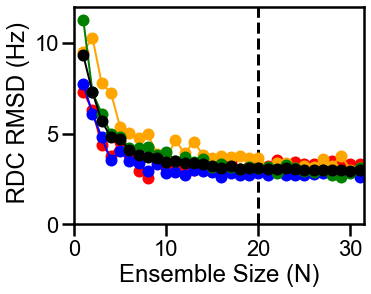

In [15]:
fig, ax = plt.subplots(figsize=(5.2,4))
ax.axvline([20], ymin=0, ymax=10, color="k", ls="--")
ax.plot(list(range(1, 36)), H1_RMSD[:35], color='red', marker='o', markersize=12, markeredgewidth=0, lw=2)
ax.plot(list(range(1, 36)), H2_RMSD[:35], color='blue', marker='o', markersize=12, markeredgewidth=0, lw=2)
ax.plot(list(range(1, 36)), B_RMSD[:35], color='orange', marker='o', markersize=12, markeredgewidth=0, lw=2)
ax.plot(list(range(1, 36)), L_RMSD[:35], color='green', marker='o', markersize=12, markeredgewidth=0, lw=2)
ax.plot(list(range(1, 36)), All_RMSD[:35], color='black', marker='o', markersize=12, markeredgewidth=0, lw=2)

plt.rcParams.update({'font.size': 20})
ax.set_xlabel("Ensemble Size (N)")
ax.set_ylabel(" RDC RMSD (Hz)")
ax.set_xlim([0, 31.5])
ax.set_ylim([0, 12])
#plt.legend(loc=(1.5, 1.5), prop={'size': 16})
plt.savefig("plots/Ensemble_N_vs_RDC_RMSD.pdf")